In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
TEST_DATE = "1002"

In [3]:
# local -> plot

task_to_scenario = []
is_picture = []
tasks = []
data_length = []
for line in open(f"test_result/{TEST_DATE}_test_local_log.txt", "r", encoding="utf-8"):
    if line.startswith("Task"):
        scenario_and_task, work_type, data, start_timestamp, elapsed_time, code, response = line.rstrip().split(" / ")
        scenario_and_task = scenario_and_task.rpartition("Task #")[2]
        scenario_id, _, task_id = scenario_and_task.partition('-')
        task_to_scenario.append(int(scenario_id))
        tasks.append((int(task_id), int(data), work_type == "image", float(start_timestamp), float(elapsed_time.partition(" sec")[0]), code))

scenarios = []
current_group_idx = 1
current_group = []
tasks.sort()
for task_id, dl, work_type, start, elapsed, code in tasks:
    data_length.append(dl)
    is_picture.append(work_type)
    if task_to_scenario[task_id-1] != current_group_idx:
        current_group_idx = task_to_scenario[task_id-1]
        scenarios.append(current_group)
        current_group = []
    current_group.append((task_id, start, elapsed))
scenarios.append(current_group)

scenario_start_time = []

for group in scenarios:
    t = min(map(lambda x: x[1], group))
    scenario_start_time.append(t)
    for i in range(len(group)):
        group[i] = (group[i][0], group[i][1] - t, group[i][2])


In [4]:
offset = 0
x = []
y = []
dy = []
for group in scenarios:
    for task in group:
        task_id, start_time, elapsed = task
        x.append(task_id + offset)
        y.append(start_time)
        dy.append(elapsed)
    offset += 2

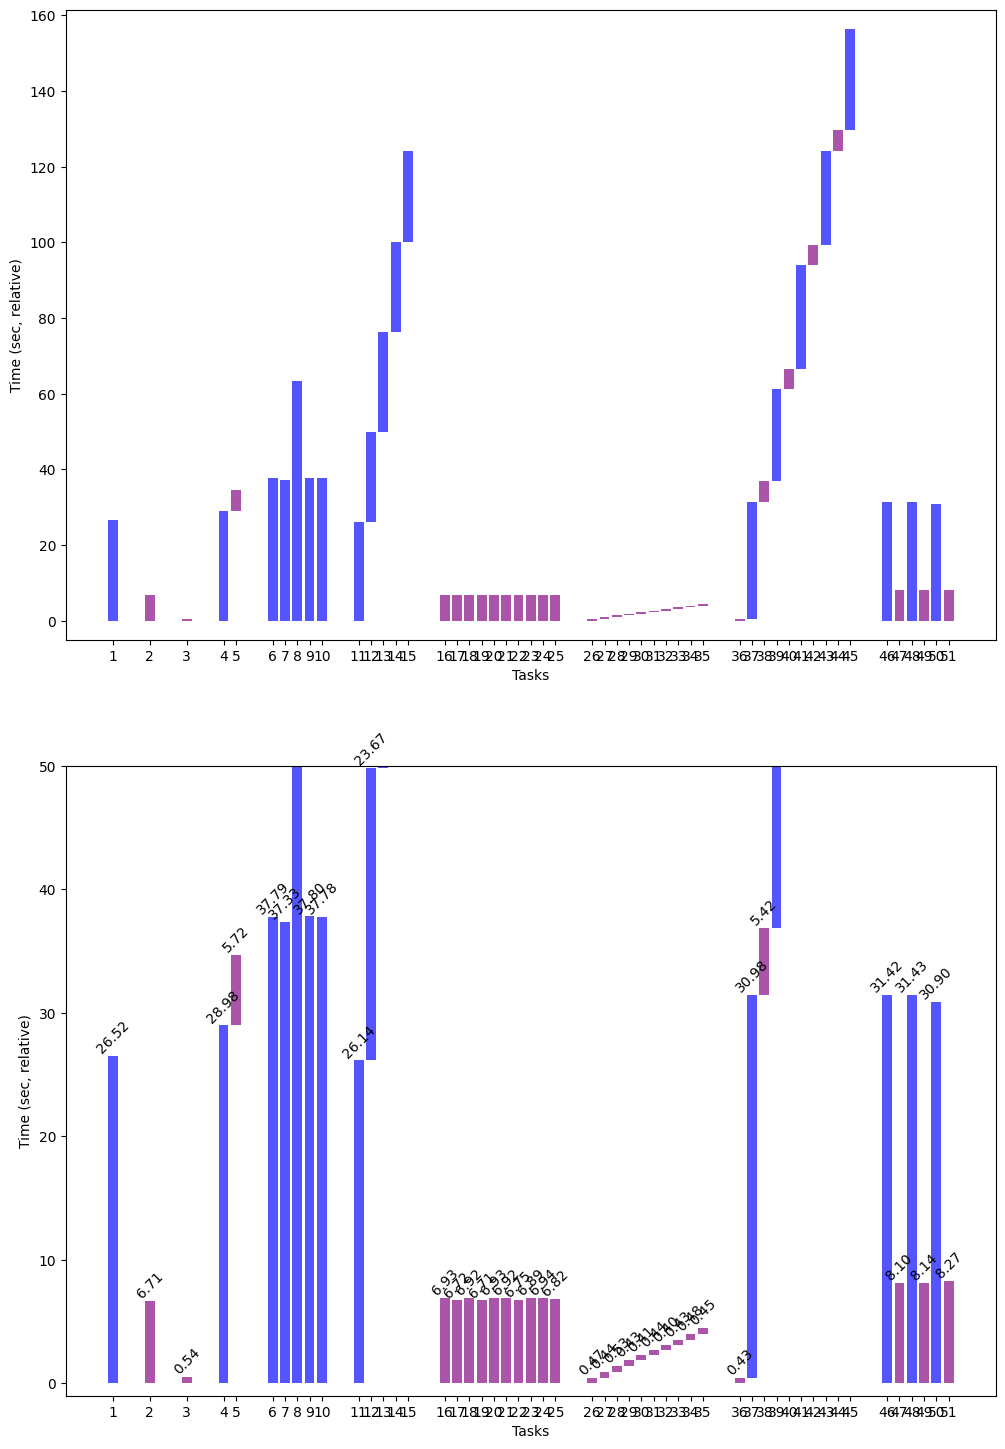

In [5]:
max_y = max(map(sum, zip(y, dy)))

colors = list(map(lambda x: "#5555ff" if x else "#aa55aa", is_picture))

fig, axes = plt.subplots(2, 1, figsize=(12, 18))
plt.setp(axes, xticks=x, xticklabels=range(1, len(tasks)+1), xlabel="Tasks", ylabel="Time (sec, relative)")

axes[0].bar(x, dy, bottom=y, color=colors)
axes[0].set_ylim(-5, max_y + 5)

b = axes[1].bar(x, dy, bottom=y, color=colors)
axes[1].bar_label(b, labels=[f"{v:.2f}" for v in dy], rotation=45)
axes[1].set_ylim(-1, 50)

plt.show()

In [6]:
# top log -> plot

def size_to_float(s: str):
    if s.isdecimal():
        return int(s)/1000000
    elif s.endswith('k'):
        return float(s[:-1])/1000
    elif s.endswith('m'):
        return float(s[:-1])
    elif s.endswith('g'):
        return float(s[:-1])*1000
    else:
        return -1

# TIMESTAMP      PID USER      PR  NI    VIRT    RES    SHR S  %CPU   SWAP  %MEM     TIME+
x = []
l_virt = []
l_res = []
l_shr = []
l_cpup = []
l_swap = []
l_memp = []
l_time_used = []
for line in open(f"test_result/{TEST_DATE}_test_top_log.txt", "r", encoding="utf-8"):
    if not line.endswith(('\r', '\n')): break
    timestamp, _, _, _, _, virt, res, shr, _, cpup, swap, memp, time_used = line.strip().split()
    x.append(int(timestamp))
    l_virt.append(size_to_float(virt))
    l_res.append(size_to_float(res))
    l_shr.append(size_to_float(shr))
    l_cpup.append(float(cpup))
    l_swap.append(size_to_float(swap))
    l_memp.append(float(memp))
    minute, _, second = time_used.partition(':')
    l_time_used.append(int(minute)*60+float(second))

x_start = x[0]
for i in range(len(x)):
    x[i] -= x_start

In [7]:
scenario_running_interval = []
for i in range(len(scenarios)):
    start_t = scenario_start_time[i] - x_start
    end_t = start_t + max(map(lambda l: l[1] + l[2], scenarios[i]))
    scenario_running_interval.append((start_t, end_t))

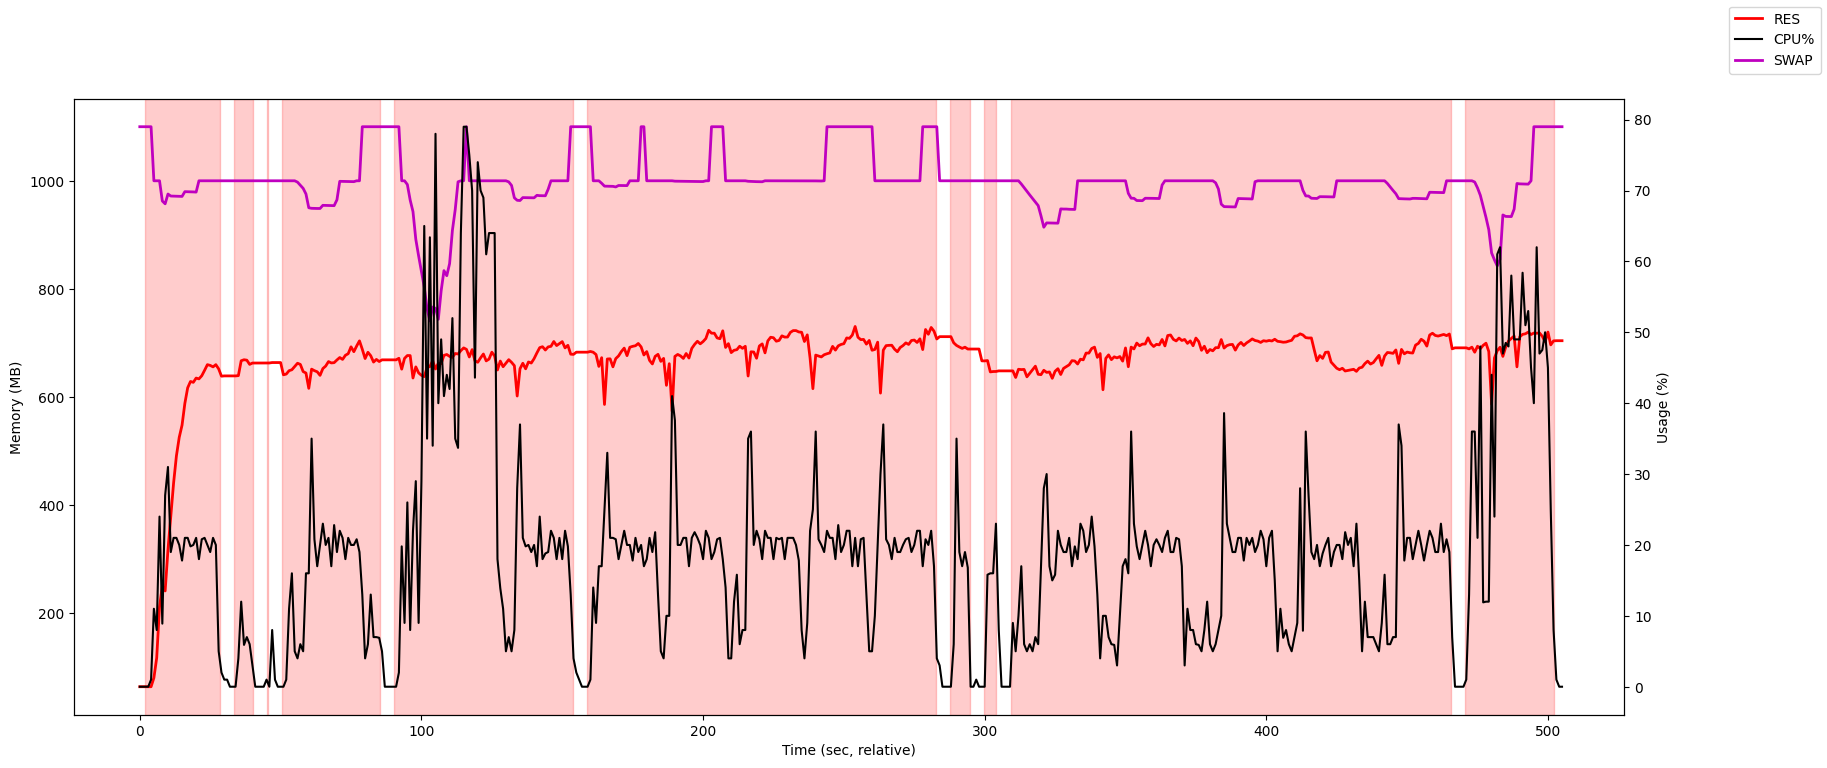

In [8]:
# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

fig, ax = plt.subplots(figsize=(20, 8))
# ax_vm = ax.twinx()
ax_percent = ax.twinx()
# ax_time = ax.twinx()

handles = []
# handles += ax_vm.plot(x, l_virt, 'g-.', label="VIRT")
handles += ax.plot(x, l_res, 'r-', linewidth=2.0, label="RES")
# handles += ax.plot(x, l_shr, 'b-.', label="SHR")
handles += ax_percent.plot(x, l_cpup, 'k-', label="CPU%")
handles += ax.plot(x, l_swap, 'm-', linewidth=2.0, label="SWAP")
# handles += ax_percent.plot(x, l_memp, 'c-', linewidth=3.0, label="MEM%")
# handles += ax_time.plot(x, l_time_used, 'y:', label="TIME+")

fig.legend(handles=handles, ncols=max(int(len(handles)**.5), 1))

ax.set_xlabel("Time (sec, relative)")
ax.set_ylabel("Memory (MB)")
# ax_vm.set_ylabel("VIRT (MB)")
ax_percent.set_ylabel("Usage (%)")
# ax_time.set_ylabel("CPU Time (sec, absolute)")

# ax_vm.spines['right'].set_visible(False)
# ax_vm.spines['left'].set_visible(True)
# ax_vm.spines['left'].set_position(('outward', 60))
# ax_vm.yaxis.set_label_position('left')
# ax_vm.yaxis.set_ticks_position('left')
# ax_time.spines['right'].set_position(('outward', 60))

sx = min(v[0] for v in scenario_running_interval)
ex = max(v[1] for v in scenario_running_interval)
dx = (ex - sx) / 20
ax.set_xlim(sx - dx, ex + dx)

for st, et in scenario_running_interval:
    ax.axvspan(st, et, alpha=0.2, color='red')

plt.show()

In [9]:
# vmstat -> plot

# procs -----------memory---------- ---swap-- -----io---- -system-- -------cpu------- -----timestamp-----
# r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st gu                 UTC

from datetime import datetime, timezone

x = []
l_proc_run = []
l_proc_block = []
l_mem_swpd = []
l_mem_free = []
l_mem_buff = []
l_mem_cache = []
l_swp_in = []
l_swp_out = []
l_io_in = []
l_io_out = []
l_sys_intr = []
l_sys_cs = []
l_cpu_user = []
l_cpu_sys = []
l_cpu_idle = []
l_cpu_wa = []
l_cpu_st = []
l_cpu_gu = []

for line in open(f"test_result/{TEST_DATE}_test_vmstat_log.txt", "r", encoding="utf-8"):
    line = line.strip()
    if line.startswith(("procs", "r")):
        continue
    proc_run, proc_block, \
        mem_swpd, mem_free, mem_buff, mem_cache, \
        swp_in, swp_out, io_in, io_out, sys_intr, sys_cs, \
        cpu_user, cpu_sys, cpu_idle, cpu_wa, cpu_st, cpu_gu, *timestamp = line.split()
    l_proc_run.append(int(proc_run))
    l_proc_block.append(int(proc_block))
    l_mem_swpd.append(int(mem_swpd)/1000)
    l_mem_free.append(int(mem_free)/1000)
    l_mem_buff.append(int(mem_buff)/1000)
    l_mem_cache.append(int(mem_cache)/1000)
    l_swp_in.append(int(swp_in)/1000)
    l_swp_out.append(int(swp_out)/1000)
    l_io_in.append(int(io_in)/1000)
    l_io_out.append(int(io_out)/1000)
    l_sys_intr.append(int(sys_intr))
    l_sys_cs.append(int(sys_cs))
    l_cpu_user.append(int(cpu_user))
    l_cpu_sys.append(int(cpu_sys))
    l_cpu_idle.append(int(cpu_idle))
    l_cpu_wa.append(int(cpu_wa))
    l_cpu_st.append(int(cpu_st))
    l_cpu_gu.append(int(cpu_gu))
    x.append(datetime.strptime(' '.join(timestamp), "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp())

x_start = x[0]
for i in range(len(x)):
    x[i] -= x_start

In [10]:
scenario_running_interval = []
for i in range(len(scenarios)):
    start_t = scenario_start_time[i] - x_start
    end_t = start_t + max(map(lambda l: l[1] + l[2], scenarios[i]))
    scenario_running_interval.append((start_t, end_t))

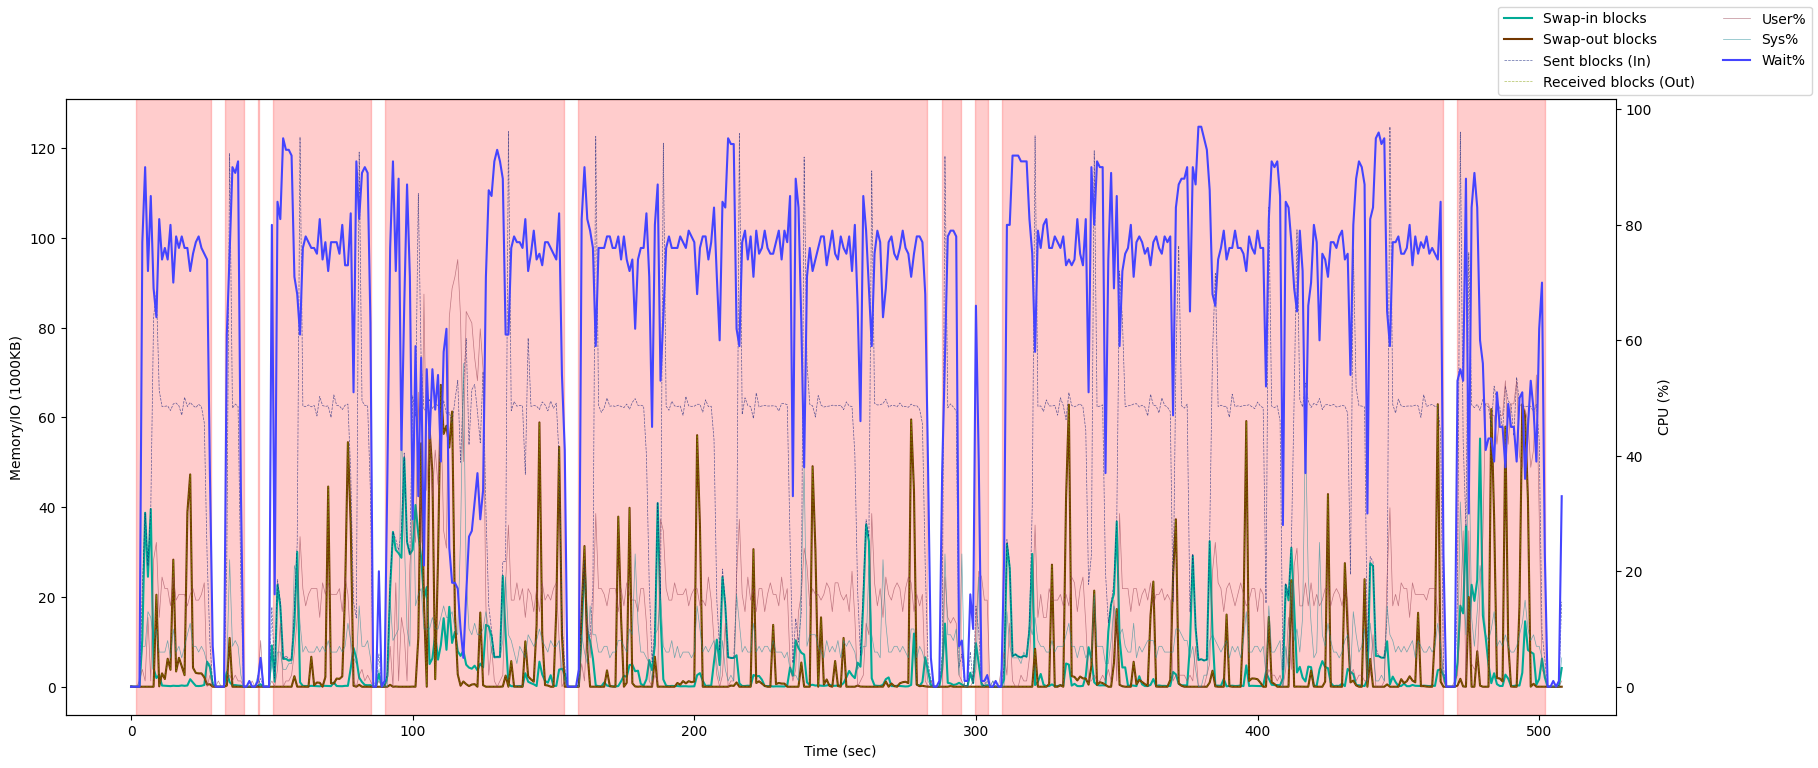

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))
# ax_proc = ax.twinx()
# ax_sys = ax.twinx()
ax_percent = ax.twinx()

handles = []
# handles += ax_proc.plot(x, l_proc_run, '-', label="Running process", c="#00a000a0")
# handles += ax_proc.plot(x, l_proc_block, '-', label="Blocked process", c="#a00000a0")
# handles += ax.plot(x, l_mem_swpd, '--', label="Swapped memory", linewidth=2.0, c="#ff00ff")
# handles += ax.plot(x, l_mem_free, '--', label="Free memory", c="#00c7b6a0")
# handles += ax.plot(x, l_mem_buff, '--', label="Buffed memory", c="#c777009f")
# handles += ax.plot(x, l_mem_cache, '--', label="Cached memory", c="#23ff409f")
handles += ax.plot(x, l_swp_in, '-', label="Swap-in blocks", c="#00aa95")
handles += ax.plot(x, l_swp_out, '-', label="Swap-out blocks", c="#723700")
handles += ax.plot(x, l_io_in, '--', label="Sent blocks (In)", linewidth=0.5, c="#001172a0")
handles += ax.plot(x, l_io_out, '--', label="Received blocks (Out)", linewidth=0.5, c="#809C00a0")
# handles += ax_sys.plot(x, l_sys_intr, '-.', label="Interrupted", c="#3B0072a0")
# handles += ax_sys.plot(x, l_sys_cs, '-.', label="Context switched", c="#aca9009f")
handles += ax_percent.plot(x, l_cpu_user, '-', label="User%", linewidth=0.5, c="#994455a0")
handles += ax_percent.plot(x, l_cpu_sys, '-', label="Sys%", linewidth=0.5, c="#228c97a0")
# handles += ax_percent.plot(x, l_cpu_idle, '-', label="Idle%", c="#6c5a7aa0")
handles += ax_percent.plot(x, l_cpu_wa, '-', label="Wait%", c="#4444ff")
# handles += ax_percent.plot(x, l_cpu_st, ':', label="Steal%", c="#3B3B3Ba0")
# handles += ax_percent.plot(x, l_cpu_gu, ':', label="Guest%", c="#252570a0")

fig.legend(handles=handles, ncol=max(int(len(handles)**.5), 1))

sx = min(v[0] for v in scenario_running_interval)
ex = max(v[1] for v in scenario_running_interval)
dx = (ex - sx) / 20
ax.set_xlim(sx - dx, ex + dx)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Memory/IO (1000KB)")
ax.ticklabel_format(style="plain")
# ax_proc.set_ylabel("Processes")
# ax_sys.set_ylabel("Amount of Interruption/Context switching")
ax_percent.set_ylabel("CPU (%)")

# for i, tax in enumerate([ax, ax_proc]):
for i, tax in enumerate([ax]):
    tax.spines['right'].set_visible(False)
    tax.spines['left'].set_visible(True)
    tax.spines['left'].set_position(('outward', 60 * i))
    tax.yaxis.set_label_position('left')
    tax.yaxis.set_ticks_position('left')
# for i, tax in enumerate([ax_percent, ax_sys]):
for i, tax in enumerate([ax_percent]):
    tax.spines['right'].set_position(('outward', 60 * i))
    tax.yaxis.set_label_position('right')
    tax.yaxis.set_ticks_position('right')

for st, et in scenario_running_interval:
    ax.axvspan(st, et, alpha=0.2, color='red')

plt.show()